In [11]:
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import datasets
from datasets import load_dataset
from transformers import PreTrainedTokenizerFast

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten,Embedding,Dense,LSTM,Dropout,GRU
import gc

In [28]:
rand_seed = 9
use_pre_trained_embd_layer = False
use_googletrans_aug_data = True
save_model = True

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.keras.utils.set_random_seed(rand_seed)
    
seed_everything(rand_seed)

In [29]:
nepCov19 = load_dataset("raygx/NepCov19Tweets").shuffle(rand_seed)

if use_googletrans_aug_data:
    print("\nAdding Data to Neutral class \n- augmented through googletrans \n- ne-2-en-2-ne\n")
    aug_data = pd.read_csv("../augment/googletrans_augmented_data.csv")
    aug_data = aug_data.rename(columns={"Unnamed: 0":"Sentiment","ne":"Sentences"})
    aug_data['Sentiment'] = np.zeros(aug_data.shape[0],dtype=np.int32)
    nepCov19 = datasets.DatasetDict({
        'train':datasets.concatenate_datasets([
                    nepCov19.filter(lambda x: x['Sentiment']!=0)['train'], # because augdata already contains original as well
                    datasets.Dataset.from_pandas(aug_data) 
                ])     
        })  
    
nepCov19

Found cached dataset parquet (C:/Users/Dell/.cache/huggingface/datasets/raygx___parquet/raygx--NepCov19Tweets-11ff376905985191/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached shuffled indices for dataset at C:\Users\Dell\.cache\huggingface\datasets\raygx___parquet\raygx--NepCov19Tweets-11ff376905985191\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-36e384585e68d3b4.arrow
Loading cached processed dataset at C:\Users\Dell\.cache\huggingface\datasets\raygx___parquet\raygx--NepCov19Tweets-11ff376905985191\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-2f4ee948a2e009d2.arrow



Adding Data to Neutral class 
- augmented through googletrans 
- ne-2-en-2-ne



DatasetDict({
    train: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 38194
    })
})

In [30]:
tokenizer = PreTrainedTokenizerFast.from_pretrained("raygx/GPT2-Nepali-Casual-LM")
max_len = 95

In [36]:
def LabelEncoding(x):
    if x==0:
        return [1,0,0]
    if x==1:
        return [0,1,0]
    if x==-1:
        return [0,0,1]
    
    return x

nepCov19 = nepCov19['train'].train_test_split(test_size=0.2)
print("Dataset",nepCov19)

print("Preparing Training Input and Labels")
train_input = pad_sequences(
                        tokenizer(
                            nepCov19['train'].select(range(10000))['Sentences']
                            ).input_ids,
                        maxlen = max_len,
                        padding='post',
                        value=tokenizer.pad_token_id
                    )
train_labels = [LabelEncoding(x) for x in nepCov19['train']['Sentiment']][:10000]

print("Preparing Test Input and Labels")
test_input = pad_sequences(
                        tokenizer(
                            nepCov19['test']['Sentences']
                            ).input_ids,
                        maxlen = max_len,
                        padding='post',
                        value=tokenizer.pad_token_id
                    )
test_labels = [LabelEncoding(x) for x in nepCov19['test']['Sentiment']]

Loading cached split indices for dataset at C:\Users\Dell\.cache\huggingface\datasets\raygx___parquet\raygx--NepCov19Tweets-11ff376905985191\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-2dd07c9a19407645.arrow and C:\Users\Dell\.cache\huggingface\datasets\raygx___parquet\raygx--NepCov19Tweets-11ff376905985191\0.0.0\2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec\cache-0a25f396b370d8b6.arrow


Dataset DatasetDict({
    train: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 24444
    })
    test: Dataset({
        features: ['Sentiment', 'Sentences'],
        num_rows: 6111
    })
})
Preparing Training Input and Labels
Preparing Test Input and Labels


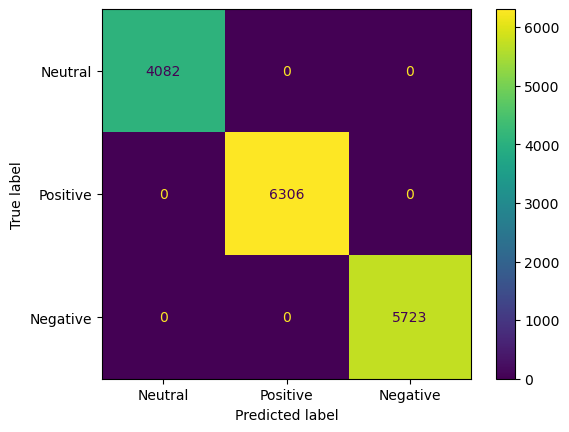

In [37]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cmd = ConfusionMatrixDisplay(
            tf.math.confusion_matrix(
                [np.argmax(x) for x in train_labels+test_labels],[np.argmax(x) for x in train_labels+test_labels],num_classes=3
            ).numpy(),
            display_labels=['Neutral',"Positive","Negative"]
        )
cmd.plot()

In [38]:
### https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/136542#136542
n_hidden = int(len(train_labels)/(2*(95 + 3)))

In [39]:
try:
    raise("Let's Build New Model")
    print("Loading saved model")
    model = tf.keras.models.load_model("saved_models/LSTM_4_SA")
    print(model.summary())
except:
    with tf.device('/device:CPU:0'):#For LSTM CPU works better
        embd_layer = Embedding(len(tokenizer), 38, input_length=max_len)
        
        if use_pre_trained_embd_layer:
            print("\n****Using Pre-Trained Embedding Layer****\n")
            embd_layer = tf.keras.models.load_model("../saved_models/Conv_4_SA").get_layer(index=0)
        
        model = Sequential()
        model.add(embd_layer)
        model.add(LSTM(n_hidden,activation='relu',return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(int(n_hidden/2),activation='relu'))
        model.add(Dropout(0.3))
        model.add(Flatten())
        model.add(Dense(512,activation='relu'))
        model.add(Dropout(0.4))
        model.add(Dense(128,activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(3,activation='sigmoid'))
        
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss='categorical_crossentropy',
            metrics=['acc',tf.keras.metrics.Precision()])

        print(model.summary())
        history = model.fit(tf.constant(train_input),
                tf.constant(train_labels),
                epochs=15)

        if save_model:
            print("Saving the model")
            model.save(os.path.join(os.getcwd(),"../saved_models/LSTM_4_SA"))
            


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 95, 38)            1900000   
                                                                 
 lstm_9 (LSTM)               (None, 95, 51)            18360     
                                                                 
 dropout_18 (Dropout)        (None, 95, 51)            0         
                                                                 
 lstm_10 (LSTM)              (None, 25)                7700      
                                                                 
 dropout_19 (Dropout)        (None, 25)                0         
                                                                 
 flatten_4 (Flatten)         (None, 25)                0         
                                                                 
 dense_14 (Dense)            (None, 512)              

In [ ]:
print("l\n\n******Evaluations***********\n")
pred_labels = [np.argmax(x) for x in 
        tf.nn.softmax(
            model.predict(
                x=tf.constant(test_input)
            )
        )
    ]

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

test_labels = [np.argmax(x) for x in test_labels]
print("F1-Score",f1_score(test_labels,pred_labels,average='weighted'))
print("Precision-Score",precision_score(test_labels,pred_labels,average='weighted'))
print("Recall-Score",recall_score(test_labels,pred_labels,average='weighted'))
print("accuracy_Score",accuracy_score(test_labels,pred_labels))


from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

confusion_matrix = tf.math.confusion_matrix(test_labels,pred_labels,num_classes=3)
print(confusion_matrix)
cmd = ConfusionMatrixDisplay(confusion_matrix.numpy(),
            display_labels=['Neutral',"Positive","Negative"])
cmd.plot()
# plt.show()
print("True Labels Onlys",tf.math.confusion_matrix(test_labels,test_labels,num_classes=3))


In [10]:
"""
-- Using NepCov19Tweets Dataset As it is --
    BEST_RESULT: 
        F1-Score: 0.7022021185799427
        Precision-Score: 0.700344004267401
        Recall-Score: 0.7054518297236744
        accuracy_Score: 0.7054518297236744
        confusion matrix:
                [[ 366  358  224]
                [ 236 2304  432]
                [ 217  505 2053]]
    HyperParameters:        
        rand_seed: 9 ## Seed for model weights and train_test data shuffle
        epochs: 5
        max_len: 95 ## maximum input length
        embedding_size: 380
        optimizer: tf.keras.optimizers.Adam(lr=0.000099)
        loss: sparse_categorical_crossentropy
        Conv1_l1: 
            units: (32,5)
            activation: relu
        maxpool_l1: 3
        Dense_1: 
            units: 100 
            activation: relu
        Dense_2: 
            units: 3 
            activation: softmax
"""



'\n-- Using NepCov19Tweets Dataset As it is --\n    BEST_RESULT: \n        F1-Score: 0.7022021185799427\n        Precision-Score: 0.700344004267401\n        Recall-Score: 0.7054518297236744\n        accuracy_Score: 0.7054518297236744\n        confusion matrix:\n                [[ 366  358  224]\n                [ 236 2304  432]\n                [ 217  505 2053]]\n    HyperParameters:        \n        rand_seed: 9 ## Seed for model weights and train_test data shuffle\n        epochs: 5\n        max_len: 95 ## maximum input length\n        embedding_size: 380\n        optimizer: tf.keras.optimizers.Adam(lr=0.000099)\n        loss: sparse_categorical_crossentropy\n        Conv1_l1: \n            units: (32,5)\n            activation: relu\n        maxpool_l1: 3\n        Dense_1: \n            units: 100 \n            activation: relu\n        Dense_2: \n            units: 3 \n            activation: softmax\n'

In [ ]:
"""
-- Added Neutral Labeled News Data and Aggregated Data --
    BEST_RESULT: 
        F1-Score: 0.7125462813535781
        Precision-Score: 0.7153736474011517
        Recall-Score: 0.7106991680046708
        accuracy_Score: 0.7106991680046708
        confusion matrix:
                [[ 586  314  195]
                 [ 317 2255  398]
                 [ 298  460 2028]]
    HyperParameters:        
        rand_seed: 9 ## Seed for model weights and train_test data shuffle
        epochs: 5
        max_len: 95 ## maximum input length
        embedding_size: 380
        optimizer: tf.keras.optimizers.Adam(lr=0.000099)
        loss: sparse_categorical_crossentropy
        Conv1_l1: 
            units: (64,5)
            activation: relu
        maxpool_l1: 3
        Conv1_l2: 
            units: (32,5)
            activation: relu
        maxpool_l2: 3
        Dense_1: 
            units: 156 
            activation: relu
        Dense_2: 
            units: 3 
            activation: softmax
"""